In [16]:
!pip install matplotlib statistics pandas numpy seaborn

In [17]:
import random
import heapq
import statistics
from collections import deque, defaultdict
from enum import Enum

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================

class RoutingAlgo(Enum):
    ECMP = "ECMP (Hash)"
    SPRAY = "SPRAY (Round-Robin)"
    ADAPTIVE = "ADAPTIVE (Least-Queue)"

class SimConfig:
    def __init__(self, k=8, bandwidth_gbps=64.0, buffer_size=64, link_delay_ns=200,
                 routing=RoutingAlgo.ECMP, cc_enabled=False, static_window=16):
        self.k = k
        self.bandwidth_bits = bandwidth_gbps * 1e9
        self.buffer_size = buffer_size
        self.link_delay = link_delay_ns * 1e-9
        self.routing = routing

        # FLOW CONTROL
        # Window=16 (Safe mode) vs Window=100 (Kill mode)
        self.static_window = static_window

        # TRANSPORT & CC
        self.cc_enabled = cc_enabled
        self.rto_seconds = 1e-3
        self.max_retries = 5
        self.ecn_threshold = 20
        self.initial_cwnd = 16
        self.min_cwnd = 2

# ==============================================================================
# 2. PHYSICAL LAYER
# ==============================================================================

class PacketType(Enum):
    DATA = 1
    ACK = 2
    CNP = 3

class Packet:
    def __init__(self, src, dst, flow_id, size_bytes, seq_num, birth_time=None, kind=PacketType.DATA):
        self.src = src
        self.dst = dst
        self.flow_id = flow_id
        self.size = size_bytes
        self.seq = seq_num
        self.kind = kind
        self.birth_time = birth_time
        self.retries = 0
        self.ecn_marked = False

    def __repr__(self):
        k_tag = self.kind.name
        return f"[{k_tag} {self.flow_id}-{self.seq} r{self.retries}]"

class Link:
    def __init__(self, config, name="Link"):
        self.rate = config.bandwidth_bits
        self.delay = config.link_delay
        self.is_transmitting = False
        self.name = name

    def transmission_time(self, size_bytes):
        return (size_bytes * 8) / self.rate

class Node:
    def __init__(self, node_id, node_type, config):
        self.id = node_id
        self.type = node_type
        self.name = f"{node_type.upper()}-{node_id}"
        self.config = config
        self.ports = {}
        self.queues = {}
        self.forwarding_table = defaultdict(list)

        # STATE
        self.flow_cwnd = defaultdict(lambda: config.initial_cwnd)
        self.flow_inflight = defaultdict(int)
        self.sender_buffer = defaultdict(deque)
        self.pending_acks = {}
        self.rx_next_seq = defaultdict(int)
        self.rx_buffer = defaultdict(dict)
        self.received_data = defaultdict(set)

        self.stats = {'drops': 0, 'tx': 0, 'rx': 0, 'peak_queue': 0, 'retransmits': 0, 'ecn_marks': 0, 'cnp_signals': 0}

    def init_hardware(self, radix):
        for i in range(radix):
            # Servers = Infinite Buffer (RAM), Switches = Finite Buffer (ASIC)
            if self.type == 'server':
                self.queues[i] = deque(maxlen=None)
            else:
                self.queues[i] = deque(maxlen=self.config.buffer_size)

    def connect(self, port_idx, neighbor, link):
        self.ports[port_idx] = {'neighbor': neighbor, 'link': link}

    def add_route(self, dst_id, port_idx):
        self.forwarding_table[dst_id].append(port_idx)

    def get_next_port(self, packet):
        if packet.dst == self.id: return -1
        candidates = self.forwarding_table.get(packet.dst, [])
        if not candidates: return None
        if len(candidates) == 1: return candidates[0]

        if self.config.routing == RoutingAlgo.ECMP:
            h = hash((packet.flow_id, packet.src, packet.dst))
            return candidates[h % len(candidates)]

        elif self.config.routing == RoutingAlgo.SPRAY:
            return candidates[packet.seq % len(candidates)]

        elif self.config.routing == RoutingAlgo.ADAPTIVE:
            choices = random.sample(candidates, min(2, len(candidates)))
            if len(self.queues[choices[0]]) <= len(self.queues[choices[1]]):
                return choices[0]
            else:
                return choices[1]

        return candidates[0]

# ==============================================================================
# 3. TOPOLOGY
# ==============================================================================

class FatTreeTopology:
    def __init__(self, config):
        self.c = config
        self.nodes = {}
        self.servers = []
        self.num_servers = (config.k ** 3) // 4
        self.num_pods = config.k
        self._build_hardware()
        self._wire_connections()
        self._program_routes()

    def _build_hardware(self):
        k = self.c.k
        s_ctr = 0
        for i in range(self.num_servers):
            n = Node(s_ctr, 'server', self.c)
            n.init_hardware(1)
            self.nodes[s_ctr] = n
            self.servers.append(n)
            s_ctr += 1
        self.edges = []
        for _ in range(self.num_pods * (k//2)):
            n = Node(s_ctr, 'edge', self.c)
            n.init_hardware(k)
            self.nodes[s_ctr] = n
            self.edges.append(n)
            s_ctr += 1
        self.aggs = []
        for _ in range(self.num_pods * (k//2)):
            n = Node(s_ctr, 'agg', self.c)
            n.init_hardware(k)
            self.nodes[s_ctr] = n
            self.aggs.append(n)
            s_ctr += 1
        self.cores = []
        for _ in range((k//2)**2):
            n = Node(s_ctr, 'core', self.c)
            n.init_hardware(k)
            self.nodes[s_ctr] = n
            self.cores.append(n)
            s_ctr += 1

    def _add_link(self, u, u_port, v, v_port):
        name = f"{u.name}<->{v.name}"
        link = Link(self.c, name)
        u.connect(u_port, v, link)
        v.connect(v_port, u, link)

    def _wire_connections(self):
        k = self.c.k
        hk = k // 2
        srv_ptr = 0
        for edge in self.edges:
            for p in range(hk):
                srv = self.servers[srv_ptr]
                self._add_link(edge, p, srv, 0)
                srv_ptr += 1
        for pod_id in range(self.num_pods):
            start_edge = pod_id * hk
            start_agg = pod_id * hk
            pod_edges = self.edges[start_edge : start_edge + hk]
            pod_aggs = self.aggs[start_agg : start_agg + hk]
            for e_i, edge in enumerate(pod_edges):
                for a_i, agg in enumerate(pod_aggs):
                    self._add_link(edge, hk + a_i, agg, e_i)
        for pod_id in range(self.num_pods):
            start_agg = pod_id * hk
            pod_aggs = self.aggs[start_agg : start_agg + hk]
            for a_i, agg in enumerate(pod_aggs):
                start_core = a_i * hk
                for stride in range(hk):
                    core = self.cores[start_core + stride]
                    self._add_link(agg, hk + stride, core, pod_id)

    def _program_routes(self):
        k = self.c.k
        hk = k // 2
        for s in self.servers:
            for t in self.servers:
                if s != t: s.add_route(t.id, 0)
        for core in self.cores:
            for pod_id in range(self.num_pods):
                start_s = pod_id * ((k ** 2)//4)
                end_s = start_s + ((k ** 2)//4)
                for sid_idx in range(start_s, end_s):
                    core.add_route(self.servers[sid_idx].id, pod_id)
        for pod_id in range(self.num_pods):
            start_agg = pod_id * hk
            aggs_in_pod = self.aggs[start_agg : start_agg + hk]
            pod_start_s = pod_id * ((k ** 2)//4)
            pod_end_s = pod_start_s + ((k ** 2)//4)
            my_pod_servers = {self.servers[i].id for i in range(pod_start_s, pod_end_s)}
            for agg in aggs_in_pod:
                start_edge_idx = pod_id * hk
                edges_in_pod = self.edges[start_edge_idx : start_edge_idx + hk]
                for e_local_idx, edge in enumerate(edges_in_pod):
                    global_edge_idx = start_edge_idx + e_local_idx
                    edge_start_s = global_edge_idx * hk
                    edge_end_s = edge_start_s + hk
                    for s_idx in range(edge_start_s, edge_end_s):
                        agg.add_route(self.servers[s_idx].id, e_local_idx)
                uplinks = list(range(hk, k))
                for s in self.servers:
                    if s.id not in my_pod_servers:
                        for up in uplinks: agg.add_route(s.id, up)
        edge_global_idx = 0
        for edge in self.edges:
            edge_start_s = edge_global_idx * hk
            edge_end_s = edge_start_s + hk
            my_servers = set()
            for local_port, s_idx in enumerate(range(edge_start_s, edge_end_s)):
                target_id = self.servers[s_idx].id
                edge.add_route(target_id, local_port)
                my_servers.add(target_id)
            uplinks = list(range(hk, k))
            for s in self.servers:
                if s.id not in my_servers:
                    for up in uplinks: edge.add_route(s.id, up)
            edge_global_idx += 1

# ==============================================================================
# 4. SIMULATOR
# ==============================================================================

class EventType(Enum):
    APP_SEND = 1
    TIMEOUT = 2
    ARRIVAL = 3
    TX_COMPLETE = 4

class Event:
    def __init__(self, time, type, packet, node_id, port_id=None):
        self.time = time
        self.type = type
        self.packet = packet
        self.node_id = node_id
        self.port_id = port_id
    def __lt__(self, other): return self.time < other.time

class Simulator:
    def __init__(self, topo):
        self.topo = topo
        self.events = []
        self.time = 0.0
        self.app_latencies = []
        self.stats = {'delivered_data': 0, 'dropped': 0, 'retransmits': 0, 'generated': 0, 'cnp_signals': 0}

    def schedule(self, delay, type, packet, node_id, port_id=None):
        heapq.heappush(self.events, Event(self.time + delay, type, packet, node_id, port_id))

    def run(self):
        print(f"--- SIM START ---")
        safety_max_events = 100_000_000
        events_processed = 0

        while self.events:
            if events_processed > safety_max_events:
                print(f"!!! EMERGENCY STOP: Event Loop Limit !!!")
                break
            ev = heapq.heappop(self.events)
            self.time = ev.time
            events_processed += 1

            if ev.type == EventType.APP_SEND:
                self.handle_app_send(ev.packet, ev.node_id)
            elif ev.type == EventType.TIMEOUT:
                self.handle_timeout(ev.packet, ev.node_id)
            elif ev.type == EventType.ARRIVAL:
                self.handle_arrival(ev.packet, ev.node_id)
            elif ev.type == EventType.TX_COMPLETE:
                self.handle_tx_complete(ev.node_id, ev.port_id)

    # SENDER
    def handle_app_send(self, packet, node_id):
        node = self.topo.nodes[node_id]
        if packet.birth_time is None:
            packet.birth_time = self.time
            if packet.kind == PacketType.DATA: self.stats['generated'] += 1
        node.sender_buffer[packet.flow_id].append(packet)
        self.try_send_window(node, packet.flow_id)

    def try_send_window(self, node, flow_id):
        buffer = node.sender_buffer[flow_id]
        limit = node.flow_cwnd[flow_id] if node.config.cc_enabled else node.config.static_window

        while buffer:
            if node.flow_inflight[flow_id] >= limit: return
            packet = buffer.popleft()
            key = (packet.flow_id, packet.seq)
            node.pending_acks[key] = packet
            node.flow_inflight[flow_id] += 1
            self.schedule(node.config.rto_seconds, EventType.TIMEOUT, packet, node.id)
            self.inject_packet(packet, node.id)

    def handle_timeout(self, packet, node_id):
        node = self.topo.nodes[node_id]
        key = (packet.flow_id, packet.seq)
        if key in node.pending_acks:
            if packet.retries < node.config.max_retries:
                packet.retries += 1
                self.stats['retransmits'] += 1
                backoff = 2 ** packet.retries
                next_timeout = node.config.rto_seconds * backoff
                if node.config.cc_enabled:
                    node.flow_cwnd[packet.flow_id] = max(node.config.min_cwnd, node.flow_cwnd[packet.flow_id] / 2)
                self.schedule(next_timeout, EventType.TIMEOUT, packet, node_id)
                self.inject_packet(packet, node_id)
            else:
                node.flow_inflight[packet.flow_id] -= 1
                del node.pending_acks[key]
                self.try_send_window(node, packet.flow_id)

    def inject_packet(self, packet, node_id):
        self.handle_arrival(packet, node_id)

    # RECEIVER
    def handle_arrival(self, packet, node_id):
        node = self.topo.nodes[node_id]
        if packet.dst == node.id:
            if packet.kind == PacketType.DATA:
                flow_id = packet.flow_id
                send_cnp = packet.ecn_marked
                if packet.seq not in node.received_data[flow_id]:
                    node.received_data[flow_id].add(packet.seq)
                    self.stats['delivered_data'] += 1
                ack_pkt = Packet(node.id, packet.src, packet.flow_id, 64, packet.seq, packet.birth_time, kind=PacketType.ACK)
                self.handle_ack_send(ack_pkt, node_id)
                if send_cnp and node.config.cc_enabled:
                    cnp_pkt = Packet(node.id, packet.src, packet.flow_id, 64, packet.seq, packet.birth_time, kind=PacketType.CNP)
                    self.handle_ack_send(cnp_pkt, node_id)
            elif packet.kind == PacketType.ACK:
                key = (packet.flow_id, packet.seq)
                if key in node.pending_acks:
                    node.flow_inflight[packet.flow_id] -= 1
                    del node.pending_acks[key]
                    self.app_latencies.append(self.time - packet.birth_time)
                    if node.config.cc_enabled: node.flow_cwnd[packet.flow_id] += 1
                    self.try_send_window(node, packet.flow_id)
            elif packet.kind == PacketType.CNP:
                self.stats['cnp_signals'] += 1
                if node.config.cc_enabled:
                    node.flow_cwnd[packet.flow_id] = max(node.config.min_cwnd, node.flow_cwnd[packet.flow_id] * 0.5)
            return

        out_port = node.get_next_port(packet)
        if out_port is None: return
        queue = node.queues[out_port]
        link = node.ports[out_port]['link']
        if queue.maxlen is not None and len(queue) >= queue.maxlen:
            node.stats['drops'] += 1
            self.stats['dropped'] += 1
            return
        if node.config.cc_enabled and queue.maxlen is not None and len(queue) > node.config.ecn_threshold:
            packet.ecn_marked = True
            node.stats['ecn_marks'] += 1
        queue.append(packet)
        if len(queue) > node.stats['peak_queue']: node.stats['peak_queue'] = len(queue)
        if not link.is_transmitting: self.start_transmission(node, out_port)

    def handle_ack_send(self, packet, node_id):
        self.inject_packet(packet, node_id)

    def start_transmission(self, node, port_idx):
        queue = node.queues[port_idx]
        if not queue: return
        link = node.ports[port_idx]['link']
        neighbor = node.ports[port_idx]['neighbor']
        link.is_transmitting = True
        packet = queue[0]
        trans_delay = link.transmission_time(packet.size)
        self.schedule(trans_delay + link.delay, EventType.ARRIVAL, packet, neighbor.id)
        self.schedule(trans_delay, EventType.TX_COMPLETE, None, node.id, port_idx)

    def handle_tx_complete(self, node_id, port_idx):
        node = self.topo.nodes[node_id]
        queue = node.queues[port_idx]
        link = node.ports[port_idx]['link']
        queue.popleft()
        link.is_transmitting = False
        if queue: self.start_transmission(node, port_idx)

    # --- REPORTING ---
    def print_detailed_report(self):
        print(f"    [DETAILED REPORT]")
        total_traffic = self.stats['delivered_data'] + self.stats['dropped']
        loss_rate = 0 if total_traffic == 0 else (self.stats['dropped'] / total_traffic) * 100
        print(f"    > Traffic Stats:")
        print(f"      - Generated:   {self.stats['generated']}")
        print(f"      - Delivered:   {self.stats['delivered_data']}")
        print(f"      - Drop Events: {self.stats['dropped']} (Rate: {loss_rate:.2f}%)")
        print(f"      - CC Signals:  {self.stats['cnp_signals']} CNPs | {sum(n.stats['ecn_marks'] for n in self.topo.nodes.values())} ECN Marks")

        if self.app_latencies:
            lats = [x * 1e6 for x in self.app_latencies]
            lats.sort()
            avg = statistics.mean(lats)
            p50 = lats[int(len(lats)*0.50)]
            p90 = lats[int(len(lats)*0.90)]
            p99 = lats[int(len(lats)*0.99)]
            print(f"    > Latency CDF (End-to-End):")
            print(f"      - Avg: {avg:.2f}us")
            print(f"      - P50: {p50:.2f}us | P90: {p90:.2f}us | P99: {p99:.2f}us")
        else: print(f"    > Latency Stats: N/A")

    def audit_inflight(self):
        buffered = sum(len(q) for n in self.topo.nodes.values() for q in n.queues.values())
        print(f"    > In-Flight: {buffered} Buffered in Queues")

# ==============================================================================
# 5. TEST SUITE
# ==============================================================================

class TrafficGen:
    def __init__(self, sim):
        self.sim = sim

    def generate_random_permutation_bursts(self, burst_size):
        servers = self.sim.topo.servers
        n = len(servers)
        destinations = [s.id for s in servers]
        random.shuffle(destinations)

        count = n * burst_size
        print(f"    > Injecting {count} pkts (Random Permutation, Burst={burst_size})")
        print(f"    > Injection Pattern: Instant (Line Rate) Buffer Fill")

        for i in range(n):
            src = servers[i]
            dst_id = destinations[i]
            if src.id == dst_id: dst_id = destinations[(i+1)%n]
            for p in range(burst_size):
                pkt = Packet(src.id, dst_id, flow_id=(i*1000), size_bytes=1500, seq_num=p)
                self.sim.schedule(0.0, EventType.APP_SEND, pkt, src.id)

def run_grand_challenge():
    print("\n===========================================================")
    print("      FINAL STUDY: ROUTING vs CONGESTION (K=8, 128 Servers)")
    print("===========================================================")

    # 2 Distinct Test Groups

    # TEST GROUP A: LATENCY EFFICIENCY (Window=16)
    # Flow Control prevents drops. We measure how fast the network clears the backlog.
    # Prediction: Adaptive < ECMP < Spray

    print("\n[GROUP A: LATENCY EFFICIENCY TEST (Window=16)]")
    group_a_configs = [
        {"name": "1. ECMP", "strat": RoutingAlgo.ECMP, "cc": False, "win": 16},
        {"name": "2. SPRAY", "strat": RoutingAlgo.SPRAY, "cc": False, "win": 16},
        {"name": "3. ADAPTIVE", "strat": RoutingAlgo.ADAPTIVE, "cc": False, "win": 16},
    ]

    for c in group_a_configs:
        print(f"\n### {c['name']}")
        cfg = SimConfig(k=8, routing=c['strat'], cc_enabled=c['cc'], static_window=c['win'])
        global sim
        sim = Simulator(FatTreeTopology(cfg))
        TrafficGen(sim).generate_random_permutation_bursts(burst_size=200) # 1000 pkts > Window 16
        sim.run()
        sim.print_detailed_report()

    # TEST GROUP B: "KILL" TEST (Window=100)
    # Window > Buffer(64). Flow control allows buffer overflow.
    # Prediction: ECMP Drops Higher than Adaptive

    print("\n\n[GROUP B: KILL TEST (Window=100 > Buffer=64)]")
    group_b_configs = [
        {"name": "1. ECMP (Baseline)", "strat": RoutingAlgo.ECMP, "cc": False, "win": 100},
        {"name": "2. ADAPTIVE (Survivor)", "strat": RoutingAlgo.ADAPTIVE, "cc": False, "win": 100},
        {"name": "3. ADAPTIVE + CC (Ultra)", "strat": RoutingAlgo.ADAPTIVE, "cc": True, "win": 100},
    ]

    for c in group_b_configs:
        print(f"\n### {c['name']}")
        cfg = SimConfig(k=8, routing=c['strat'], cc_enabled=c['cc'], static_window=c['win'])
        sim = Simulator(FatTreeTopology(cfg))
        TrafficGen(sim).generate_random_permutation_bursts(burst_size=200)
        sim.run()
        sim.print_detailed_report()

if __name__ == "__main__":
    run_grand_challenge()


      FINAL STUDY: ROUTING vs CONGESTION (K=8, 128 Servers)

[GROUP A: LATENCY EFFICIENCY TEST (Window=16)]

### 1. ECMP
    > Injecting 25600 pkts (Random Permutation, Burst=200)
    > Injection Pattern: Instant (Line Rate) Buffer Fill
--- SIM START ---
    [DETAILED REPORT]
    > Traffic Stats:
      - Generated:   25600
      - Delivered:   14406
      - Drop Events: 86933 (Rate: 85.78%)
      - CC Signals:  0 CNPs | 0 ECN Marks
    > Latency CDF (End-to-End):
      - Avg: 442.29us
      - P50: 86.06us | P90: 1105.46us | P99: 2073.51us

### 2. SPRAY
    > Injecting 25600 pkts (Random Permutation, Burst=200)
    > Injection Pattern: Instant (Line Rate) Buffer Fill
--- SIM START ---
    [DETAILED REPORT]
    > Traffic Stats:
      - Generated:   25600
      - Delivered:   20080
      - Drop Events: 65361 (Rate: 76.50%)
      - CC Signals:  0 CNPs | 0 ECN Marks
    > Latency CDF (End-to-End):
      - Avg: 46076.40us
      - P50: 93.58us | P90: 126123.64us | P99: 315059.69us

### 3. AD

In [18]:
import pandas as pd
import numpy as np
import time

# ==============================================================================
# BATCH SIMULATION RUNNER
# ==============================================================================

def run_experiment_batch():
    results = []

    print(f"🚀 STARTING MASSIVE SIMULATION BATCH (Approx 3-5 mins)...")

    # -------------------------------------------------------------------------
    # EXPERIMENT 1: LATENCY & DROPS vs. LOAD (The "Hockey Stick" Curve)
    # -------------------------------------------------------------------------
    print("   [1/4] Running Load Sweep (10% -> 300% Load)...")
    # Burst sizes: 20 (Low) to 600 (Overload). Buffer fixed at 64.
    burst_sizes = [20, 40, 70, 100, 150, 200, 400, 600]
    strategies = [
        (RoutingAlgo.ECMP, False, "ECMP"),
        (RoutingAlgo.SPRAY, False, "SPRAY"),
        (RoutingAlgo.ADAPTIVE, False, "ADAPTIVE"),
        (RoutingAlgo.ADAPTIVE, True, "ADAPTIVE+CC")
    ]

    for burst in burst_sizes:
        for strat, cc, label in strategies:
            # 4Gbps bandwidth to make congestion easier to visualize
            cfg = SimConfig(k=8, bandwidth_gbps=4.0, buffer_size=64, routing=strat, cc_enabled=cc)
            sim = Simulator(FatTreeTopology(cfg))
            TrafficGen(sim).generate_random_permutation_bursts(burst_size=burst)
            sim.run()

            # Metrics
            total = sim.stats['delivered_data'] + sim.stats['dropped']
            drop_rate = (sim.stats['dropped'] / total * 100) if total > 0 else 0
            avg_lat = statistics.mean(sim.app_latencies)*1e6 if sim.app_latencies else 0
            p99_lat = sorted(sim.app_latencies)[int(len(sim.app_latencies)*0.99)]*1e6 if sim.app_latencies else 0

            results.append({
                "Experiment": "Load Sweep",
                "Load_Factor": burst, # Proxy for Load
                "Algorithm": label,
                "Drop_Rate": drop_rate,
                "Avg_Latency_us": avg_lat,
                "P99_Latency_us": p99_lat,
                "Retries": sim.stats['retransmits'],
                "Delivered": sim.stats['delivered_data']
            })

    # -------------------------------------------------------------------------
    # EXPERIMENT 2: BUFFER SIZE SENSITIVITY (Can Adaptive survive small buffers?)
    # -------------------------------------------------------------------------
    print("   [2/4] Running Buffer Size Sweep...")
    # Fixed high load (Burst 200), varying buffers
    buffers = [16, 32, 64, 128, 256]

    for buf in buffers:
        for strat, cc, label in strategies:
            cfg = SimConfig(k=8, bandwidth_gbps=4.0, buffer_size=buf, routing=strat, cc_enabled=cc)
            sim = Simulator(FatTreeTopology(cfg))
            TrafficGen(sim).generate_random_permutation_bursts(burst_size=200)
            sim.run()

            total = sim.stats['delivered_data'] + sim.stats['dropped']
            drop_rate = (sim.stats['dropped'] / total * 100) if total > 0 else 0
            avg_lat = statistics.mean(sim.app_latencies)*1e6 if sim.app_latencies else 0

            results.append({
                "Experiment": "Buffer Sweep",
                "Buffer_Size": buf,
                "Algorithm": label,
                "Drop_Rate": drop_rate,
                "Avg_Latency_us": avg_lat
            })

    # -------------------------------------------------------------------------
    # EXPERIMENT 3: CDF TAIL ANALYSIS (Detailed capture for one high-load run)
    # -------------------------------------------------------------------------
    print("   [3/4] Generating Latency CDF Data (High Load)...")
    # We only run this once per algo at High Load (Burst 200)
    for strat, cc, label in strategies:
        cfg = SimConfig(k=8, bandwidth_gbps=4.0, buffer_size=64, routing=strat, cc_enabled=cc)
        sim = Simulator(FatTreeTopology(cfg))
        TrafficGen(sim).generate_random_permutation_bursts(burst_size=200)
        sim.run()

        # Save raw latencies for CDF plotting
        for lat in sim.app_latencies:
            results.append({
                "Experiment": "CDF_Raw",
                "Algorithm": label,
                "Raw_Latency_us": lat * 1e6
            })

    print("✅ BATCH SIMULATION COMPLETE.")
    return pd.DataFrame(results)

# Run and store
df_results = run_experiment_batch()

🚀 STARTING MASSIVE SIMULATION BATCH (Approx 3-5 mins)...
   [1/4] Running Load Sweep (10% -> 300% Load)...
    > Injecting 2560 pkts (Random Permutation, Burst=20)
    > Injection Pattern: Instant (Line Rate) Buffer Fill
--- SIM START ---
    > Injecting 2560 pkts (Random Permutation, Burst=20)
    > Injection Pattern: Instant (Line Rate) Buffer Fill
--- SIM START ---
    > Injecting 2560 pkts (Random Permutation, Burst=20)
    > Injection Pattern: Instant (Line Rate) Buffer Fill
--- SIM START ---
    > Injecting 2560 pkts (Random Permutation, Burst=20)
    > Injection Pattern: Instant (Line Rate) Buffer Fill
--- SIM START ---
    > Injecting 5120 pkts (Random Permutation, Burst=40)
    > Injection Pattern: Instant (Line Rate) Buffer Fill
--- SIM START ---
    > Injecting 5120 pkts (Random Permutation, Burst=40)
    > Injection Pattern: Instant (Line Rate) Buffer Fill
--- SIM START ---
    > Injecting 5120 pkts (Random Permutation, Burst=40)
    > Injection Pattern: Instant (Line Rate)

📊 GENERATING AND SAVING CHARTS...
   ✅ Saved raw data to 'simulation_results.csv'
   ✅ Saved chart to 'main_results_grid.png'


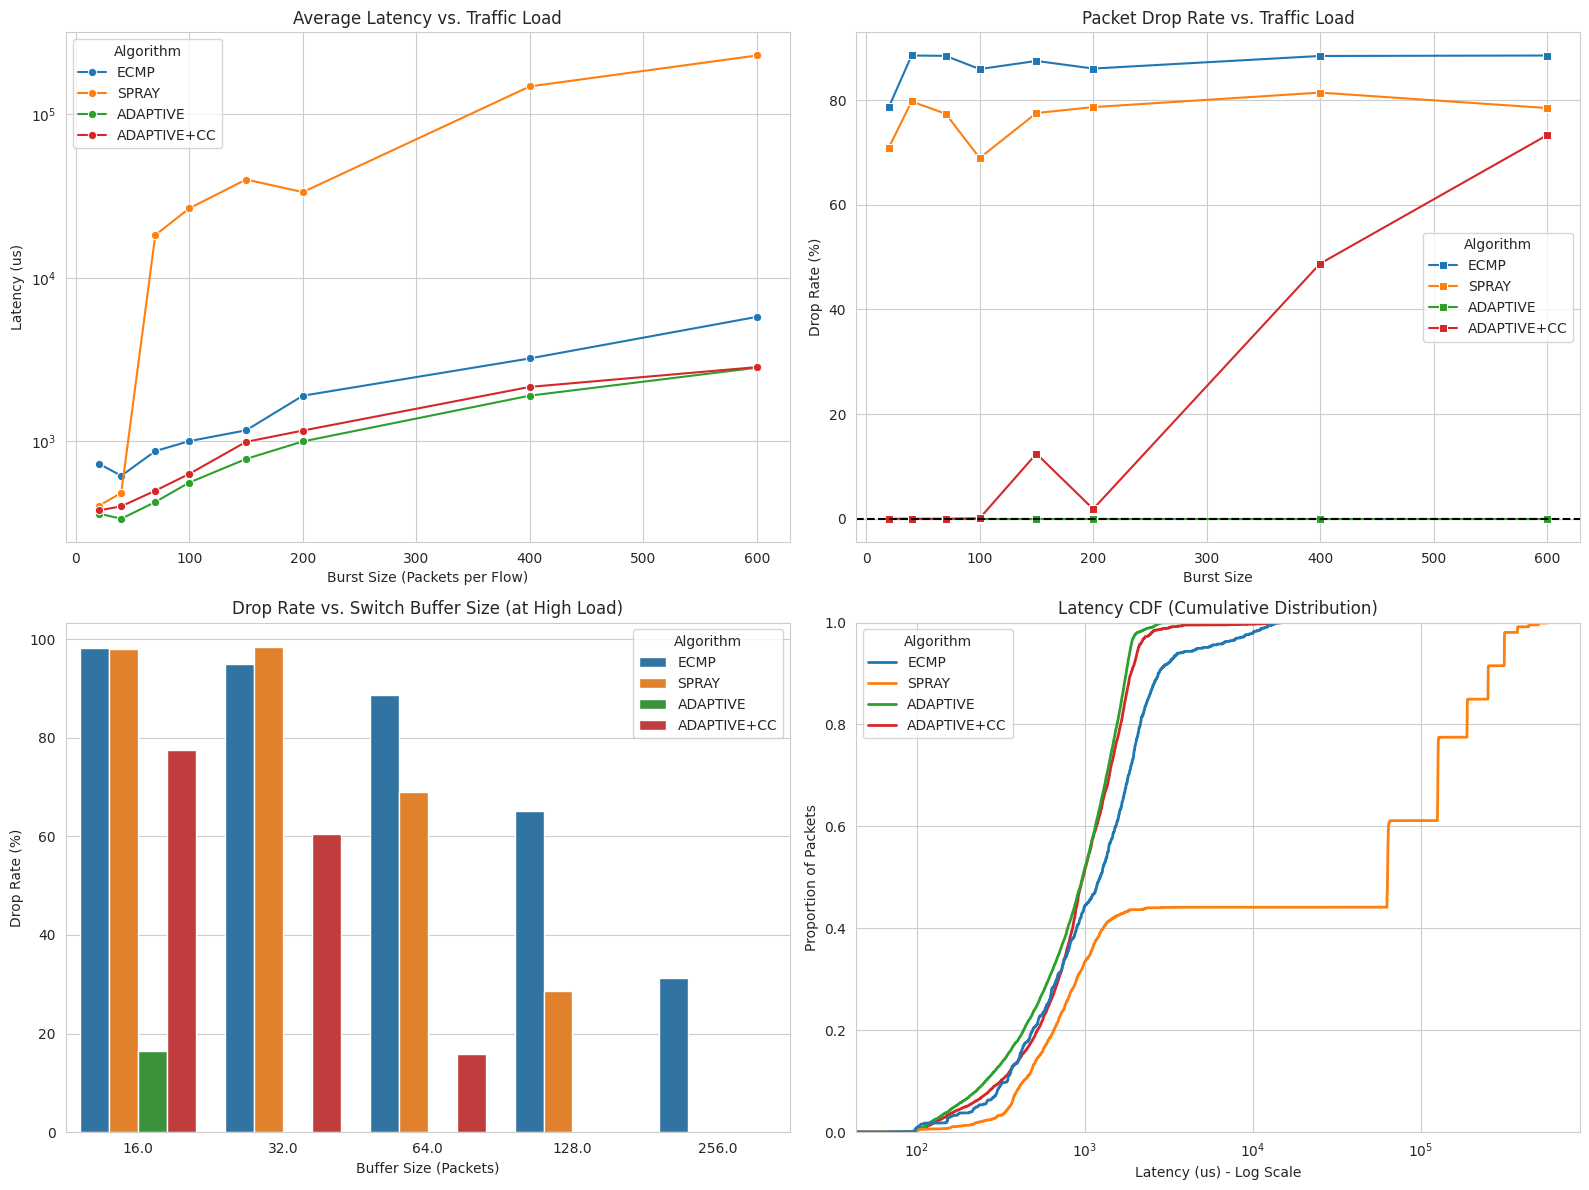

   ✅ Saved chart to 'retransmission_overhead.png'


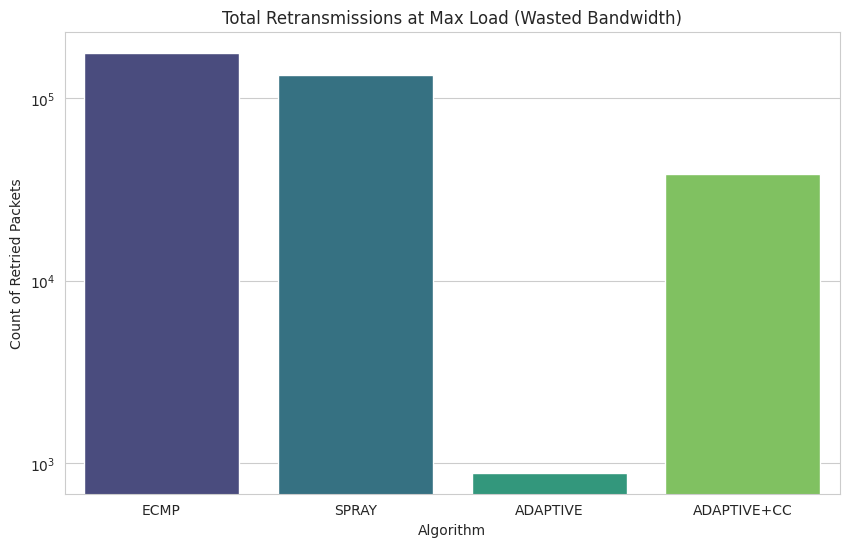

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10})

def generate_visualizations(df):
    print("📊 GENERATING AND SAVING CHARTS...")

    # [IMPORTANT] Save the raw data first
    # This ensures you never lose the results of a long simulation
    df.to_csv("simulation_results.csv", index=False)
    print("   ✅ Saved raw data to 'simulation_results.csv'")

    df_load = df[df["Experiment"] == "Load Sweep"]
    df_buff = df[df["Experiment"] == "Buffer Sweep"]
    df_cdf = df[df["Experiment"] == "CDF_Raw"]

    # ---------------------------------------------------------
    # 1. MAIN GRID (Latency, Drops, Buffer, CDF)
    # ---------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot A: Latency vs Load
    sns.lineplot(data=df_load, x="Load_Factor", y="Avg_Latency_us", hue="Algorithm", marker="o", ax=axes[0,0])
    axes[0,0].set_title("Average Latency vs. Traffic Load")
    axes[0,0].set_ylabel("Latency (us)")
    axes[0,0].set_xlabel("Burst Size (Packets per Flow)")
    axes[0,0].set_yscale("log")

    # Plot B: Drops vs Load
    sns.lineplot(data=df_load, x="Load_Factor", y="Drop_Rate", hue="Algorithm", marker="s", ax=axes[0,1])
    axes[0,1].set_title("Packet Drop Rate vs. Traffic Load")
    axes[0,1].set_ylabel("Drop Rate (%)")
    axes[0,1].set_xlabel("Burst Size")
    axes[0,1].axhline(y=0, color='black', linestyle='--')

    # Plot C: Buffer Sensitivity
    sns.barplot(data=df_buff, x="Buffer_Size", y="Drop_Rate", hue="Algorithm", ax=axes[1,0])
    axes[1,0].set_title("Drop Rate vs. Switch Buffer Size (at High Load)")
    axes[1,0].set_ylabel("Drop Rate (%)")
    axes[1,0].set_xlabel("Buffer Size (Packets)")

    # Plot D: Latency CDF
    sns.ecdfplot(data=df_cdf, x="Raw_Latency_us", hue="Algorithm", ax=axes[1,1], linewidth=2)
    axes[1,1].set_title("Latency CDF (Cumulative Distribution)")
    axes[1,1].set_xlabel("Latency (us) - Log Scale")
    axes[1,1].set_xscale("log")
    axes[1,1].set_ylabel("Proportion of Packets")

    plt.tight_layout()

    # [SAVE] Main Grid
    plt.savefig("main_results_grid.png", dpi=300, bbox_inches='tight')
    print("   ✅ Saved chart to 'main_results_grid.png'")

    plt.show()

    # ---------------------------------------------------------
    # 2. RETRANSMISSION OVERHEAD
    # ---------------------------------------------------------
    plt.figure(figsize=(10, 6))
    df_max_load = df_load[df_load["Load_Factor"] == 400]
    sns.barplot(data=df_max_load, x="Algorithm", y="Retries", hue="Algorithm", palette="viridis", legend=False)
    plt.title("Total Retransmissions at Max Load (Wasted Bandwidth)")
    plt.ylabel("Count of Retried Packets")
    plt.yscale("log")

    # [SAVE] Retransmissions
    plt.savefig("retransmission_overhead.png", dpi=300, bbox_inches='tight')
    print("   ✅ Saved chart to 'retransmission_overhead.png'")

    plt.show()

# Run it
generate_visualizations(df_results)